In [1]:
%run local_functions.py
from local_functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import BertConfig, BertModel


from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
from transformers import TrainingArguments, Trainer


from sklearn.model_selection import train_test_split

plt.style.use("dark_background")

pd.set_option("display.max_columns", 2500)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 50)


plt.style.use("dark_background")

%load_ext lab_black

2023-09-01 09:26:25.639518: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 09:26:25.660480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 09:26:25.967543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("datasets/wiki_movie_plots_deduped.csv")
df = df[["Plot", "Genre"]]
df = df.loc[df.Genre != "unknown"].reset_index(drop=True)
df["text"] = df["Plot"].apply(text_normalization_2)
df.drop("Plot", axis=1, inplace=True)
df = df[["text", "Genre"]]
# retain rows with top 100 genres
top_100_genres = df["Genre"].value_counts().head(100).index.tolist()
df = df.loc[df["Genre"].isin(top_100_genres)].reset_index(drop=True)

In [3]:
training_df, testing_df = train_test_split(df, test_size=0.25, random_state=42)

In [4]:
training_df

,text,Genre
5195,in 1866 remorseful former border raider glyn m...,western
24010,there s a war going on but that will not stop ...,drama
14976,ellie klug is a music critic in her 40s at a d...,comedy
2129,geraldine jerry darlington felt happier before...,comedy
2414,jeff scott is sent to investigate problems wit...,serial
...,...,...
21575,prithvi kumar is an honest young ias officer w...,action drama
5390,a rash of murders by an unknown monster is pla...,comedy
860,jim smith lucien littlefield a millionaire due...,musical
15795,mechanic barry lives in the australian outback...,horror


In [4]:
encoded_df = pd.get_dummies(
    training_df["Genre"], columns=["Genre"], prefix="", prefix_sep=""
)
encoded_df = encoded_df.astype(bool)
encoded_df_con = pd.concat([training_df["text"], encoded_df], axis=1)

# Dataset

In [5]:
train_df, temp_df = train_test_split(encoded_df_con, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
# Convert the split DataFrames into Datasets
train = Dataset.from_pandas(train_df, split="train")
valid = Dataset.from_pandas(valid_df, split="validation")
test = Dataset.from_pandas(test_df, split="test")

dataset = DatasetDict({"train": train, "validation": valid, "test": test})

In [7]:
labels = [
    label
    for label in dataset["train"].features.keys()
    if label not in ["text", "__index_level_0__"]
]
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Tokenize

In [8]:
LM = "distilbert-base-uncased"

In [9]:
tokenizer = AutoTokenizer.from_pretrained(LM)

In [10]:
def preprocess_data(examples):
    # take a batch of texts
    text = examples["text"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=256)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding


encoded_dataset = dataset.map(
    preprocess_data, batched=True, remove_columns=dataset["train"].column_names
)

encoded_dataset.set_format("torch")

Map:   0%|          | 0/12770 [00:00<?, ? examples/s]

Map:   0%|          | 0/2737 [00:00<?, ? examples/s]

Map:   0%|          | 0/2737 [00:00<?, ? examples/s]

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    LM,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
batch_size = 8
metric_name = "f1"

In [13]:
args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    # push_to_hub=True,
)

In [18]:
def multi_label_metrics(predictions, labels, threshold=0.5): # threshold = confidence threshold, important. 0.5 doesnt always work
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    roc_auc = roc_auc_score(y_true, y_pred, average="micro")
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {"f1": f1_micro_average, "roc_auc": roc_auc, "accuracy": accuracy}
    return metrics


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

/home/luke/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/7985 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.1391, 'learning_rate': 1.8747651847213527e-05, 'epoch': 0.31}
{'loss': 0.0421, 'learning_rate': 1.7495303694427053e-05, 'epoch': 0.63}
{'loss': 0.0406, 'learning_rate': 1.624295554164058e-05, 'epoch': 0.94}


  0%|          | 0/343 [00:00<?, ?it/s]

{'eval_loss': 0.037935301661491394, 'eval_f1': 0.05471764293230445, 'eval_roc_auc': 0.5141827481980934, 'eval_accuracy': 0.028498355864084765, 'eval_runtime': 8.3207, 'eval_samples_per_second': 328.94, 'eval_steps_per_second': 41.223, 'epoch': 1.0}
{'loss': 0.0377, 'learning_rate': 1.4990607388854104e-05, 'epoch': 1.25}
{'loss': 0.0346, 'learning_rate': 1.3738259236067628e-05, 'epoch': 1.57}
{'loss': 0.034, 'learning_rate': 1.2485911083281152e-05, 'epoch': 1.88}


  0%|          | 0/343 [00:00<?, ?it/s]

{'eval_loss': 0.03226800262928009, 'eval_f1': 0.34466403162055337, 'eval_roc_auc': 0.6187283872705868, 'eval_accuracy': 0.23894775301424917, 'eval_runtime': 8.292, 'eval_samples_per_second': 330.079, 'eval_steps_per_second': 41.365, 'epoch': 2.0}
{'loss': 0.0311, 'learning_rate': 1.123356293049468e-05, 'epoch': 2.19}
{'loss': 0.0296, 'learning_rate': 9.981214777708203e-06, 'epoch': 2.5}
{'loss': 0.0297, 'learning_rate': 8.728866624921729e-06, 'epoch': 2.82}


  0%|          | 0/343 [00:00<?, ?it/s]

{'eval_loss': 0.031020186841487885, 'eval_f1': 0.38178198108511696, 'eval_roc_auc': 0.6391684473525906, 'eval_accuracy': 0.28023383266350016, 'eval_runtime': 8.3187, 'eval_samples_per_second': 329.018, 'eval_steps_per_second': 41.232, 'epoch': 3.0}
{'loss': 0.0277, 'learning_rate': 7.476518472135255e-06, 'epoch': 3.13}
{'loss': 0.0261, 'learning_rate': 6.2241703193487794e-06, 'epoch': 3.44}
{'loss': 0.0263, 'learning_rate': 4.971822166562304e-06, 'epoch': 3.76}


  0%|          | 0/343 [00:00<?, ?it/s]

{'eval_loss': 0.03089076280593872, 'eval_f1': 0.38749384539635645, 'eval_roc_auc': 0.6427777962304817, 'eval_accuracy': 0.2875411033978809, 'eval_runtime': 8.2996, 'eval_samples_per_second': 329.776, 'eval_steps_per_second': 41.327, 'epoch': 4.0}
{'loss': 0.0254, 'learning_rate': 3.71947401377583e-06, 'epoch': 4.07}
{'loss': 0.0242, 'learning_rate': 2.4671258609893555e-06, 'epoch': 4.38}
{'loss': 0.024, 'learning_rate': 1.2147777082028805e-06, 'epoch': 4.7}


  0%|          | 0/343 [00:00<?, ?it/s]

{'eval_loss': 0.030957674607634544, 'eval_f1': 0.39805115712545674, 'eval_roc_auc': 0.6482342607662301, 'eval_accuracy': 0.29850200949945194, 'eval_runtime': 8.312, 'eval_samples_per_second': 329.282, 'eval_steps_per_second': 41.266, 'epoch': 5.0}
{'train_runtime': 741.9964, 'train_samples_per_second': 86.052, 'train_steps_per_second': 10.762, 'train_loss': 0.0372709420000529, 'epoch': 5.0}


TrainOutput(global_step=7985, training_loss=0.0372709420000529, metrics={'train_runtime': 741.9964, 'train_samples_per_second': 86.052, 'train_steps_per_second': 10.762, 'train_loss': 0.0372709420000529, 'epoch': 5.0})

In [17]:
trainer.evaluate()

  0%|          | 0/343 [00:00<?, ?it/s]

{'eval_loss': 0.030957674607634544,
 'eval_f1': 0.39805115712545674,
 'eval_roc_auc': 0.6482342607662301,
 'eval_accuracy': 0.29850200949945194,
 'eval_runtime': 8.2304,
 'eval_samples_per_second': 332.547,
 'eval_steps_per_second': 41.675,
 'epoch': 5.0}

In [18]:
#trainer.save_model("bert-finetuned-wiki-movie-plots")

# Eval 
#### should make subgenre preds count as correct

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-finetuned-wiki-movie-plots"
)
trainer = Trainer(model=model, tokenizer=tokenizer)

In [14]:
df_test = testing_df.reset_index(drop=True)

In [20]:
CONFIDENCE_THRESHOLD = 0.1


def inference(text):
    encoding = tokenizer(text, return_tensors="pt")
    encoding = {k: v.to(trainer.model.device) for k, v in encoding.items()}

    outputs = trainer.model(**encoding)

    logits = outputs.logits

    # apply sigmoid + threshold
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= CONFIDENCE_THRESHOLD)] = 1
    # turn predicted id's into actual label names
    predicted_labels = [
        id2label[idx] for idx, label in enumerate(predictions) if label == 1.0
    ]
    return predicted_labels

In [21]:
ROWS_TO_EVALUATE = len(df_test)

CONFIDENCE_THRESHOLD = 0.55  # 0.1 works well for low number of non-responses

TOP_N_PREDS = 5  # number of top predictions to return


# make predictions
df_test["predicted_class"] = df_test["text"][0:ROWS_TO_EVALUATE].apply(
    predict_class, args=(tokenizer, trainer, id2label, CONFIDENCE_THRESHOLD)
)  # args: text, tokenizer, trainer, id2label, CONFIDENCE_THRESHOLD=0.5

# calculate if prediction is correct
df_test["correct"] = df_test[0:ROWS_TO_EVALUATE].apply(
    lambda row: int(row["Genre"] in row["predicted_class"]), axis=1
)
# calculate score (including penalty for guessing multiple categories) used to help find optimal confidence threshold
df_test["correct_w_discount"] = df_test[0:ROWS_TO_EVALUATE].apply(
    multi_cat_guess_penalty,
    axis=1,
    args=(0.9,),  # muli_cat_guess_penalty (somewhere around 0.85 works well)
)

df_test["correct_w_non_preds"] = df_test.apply(multi_positive_outcome, axis=1)

# get top n predictions
df_test["top_n_preds"] = df_test["text"][0:ROWS_TO_EVALUATE].apply(
    n_most_likely_classes, args=(tokenizer, trainer, id2label, TOP_N_PREDS)
)

print(
    f"Percent of predictions that include correct class: {round((df_test.correct.sum() / ROWS_TO_EVALUATE)*100, 2)}% \nMulti_guess discount score: {round((df_test.correct_w_discount.sum() / ROWS_TO_EVALUATE)*100, 2)}%\nMulti_positive_outcome discount score: {round((df_test.correct_w_non_preds.sum() / ROWS_TO_EVALUATE)*100, 2)}%"
)
print(
    f"Percent of non-preds: {((df_test.correct_w_non_preds.sum() - df_test.correct.sum()) / ROWS_TO_EVALUATE*100)}% "
)

Percent of predictions that include correct class: 26.49% 
Multi_guess discount score: 26.49%
Multi_positive_outcome discount score: 83.2%
Percent of non-preds: 56.7083196317001% 


In [22]:
df_test.top_n_preds[3:4].values

array([{'drama': 0.527, 'thriller': 0.052, 'documentary': 0.037, 'horror': 0.026, 'science fiction': 0.024}],
      dtype=object)

In [15]:
df_test

,text,Genre
0,two married reporters daniels and lyon in new ...,comedy
1,byomkesh and ajit have been approached by mr b...,thriller
2,in the first story nightmare a businessman dis...,"comedy, horror"
3,the first third of the film is told from the m...,drama
4,aniket deepankar de is one of the finest filmm...,drama
...,...,...
6077,the location is the belarusian forests close t...,war
6078,dhinakar jai akash hailing from an ordinary mi...,romance
6079,bharat nagar is a city in modern secular india...,"action, crime, drama"
6080,the film depicts several months in the life of...,drama


Confidence Threshold: 0.05
Percent of predictions that include correct class: 67.46%
Multi_guess discount score: 53.45%
Multi_positive_outcome discount score: 67.46%
Percent of non-preds: 0.0% 
Percent of wrong preds: 32.54%
Confidence Threshold: 0.1
Percent of predictions that include correct class: 58.11%
Multi_guess discount score: 51.3%
Multi_positive_outcome discount score: 58.35%
Percent of non-preds: 0.25% 
Percent of wrong preds: 41.65%
Confidence Threshold: 0.15000000000000002
Percent of predictions that include correct class: 52.1%
Multi_guess discount score: 48.65%
Multi_positive_outcome discount score: 54.13%
Percent of non-preds: 2.02% 
Percent of wrong preds: 45.87%
Confidence Threshold: 0.2
Percent of predictions that include correct class: 47.06%
Multi_guess discount score: 45.59%
Multi_positive_outcome discount score: 53.88%
Percent of non-preds: 6.82% 
Percent of wrong preds: 46.12%
Confidence Threshold: 0.25
Percent of predictions that include correct class: 43.29%
M

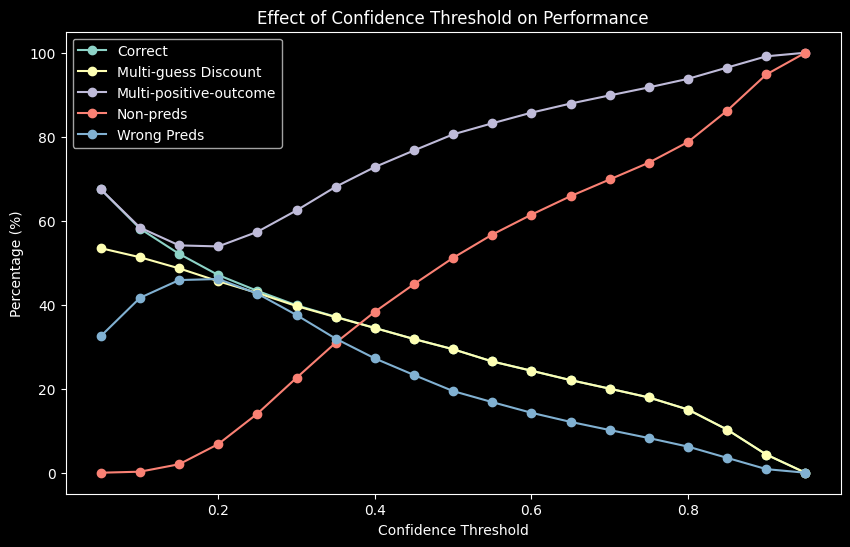

In [16]:
ROWS_TO_EVALUATE = len(df_test)
TOP_N_PREDS = 5

thresholds = []
percent_correct_list = []
percent_correct_discount_list = []
percent_correct_non_preds_list = []
percent_non_preds_list = []
percent_wrong_preds_list = []


for CONFIDENCE_THRESHOLD in np.arange(0.05, 1, 0.05):
    df_test["predicted_class"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        predict_class, args=(tokenizer, trainer, id2label, CONFIDENCE_THRESHOLD)
    )

    df_test["correct"] = df_test[:ROWS_TO_EVALUATE].apply(
        lambda row: int(row["Genre"] in row["predicted_class"]), axis=1
    )

    df_test["correct_w_discount"] = df_test[:ROWS_TO_EVALUATE].apply(
        multi_cat_guess_penalty, axis=1, args=(0.9,)
    )

    df_test["correct_w_non_preds"] = df_test[:ROWS_TO_EVALUATE].apply(
        multi_positive_outcome, axis=1
    )

    df_test["top_n_preds"] = df_test["text"][:ROWS_TO_EVALUATE].apply(
        n_most_likely_classes, args=(tokenizer, trainer, id2label, TOP_N_PREDS)
    )

    percent_correct = (df_test["correct"].sum() / ROWS_TO_EVALUATE) * 100
    percent_correct_discount = (
        df_test["correct_w_discount"].sum() / ROWS_TO_EVALUATE
    ) * 100
    percent_correct_non_preds = (
        df_test["correct_w_non_preds"].sum() / ROWS_TO_EVALUATE
    ) * 100

    percent_non_preds = (
        len(df_test[df_test.predicted_class.str.len() == 0]) / ROWS_TO_EVALUATE
    ) * 100
    percent_wrong_preds = (
        1 - (df_test.correct_w_non_preds.sum() / ROWS_TO_EVALUATE)
    ) * 100

    thresholds.append(CONFIDENCE_THRESHOLD)
    percent_correct_list.append(percent_correct)
    percent_correct_discount_list.append(percent_correct_discount)
    percent_correct_non_preds_list.append(percent_correct_non_preds)
    percent_non_preds_list.append(percent_non_preds)
    percent_wrong_preds_list.append(percent_wrong_preds)

    print(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}")
    print(
        f"Percent of predictions that include correct class: {round(percent_correct, 2)}%"
    )
    print(f"Multi_guess discount score: {round(percent_correct_discount, 2)}%")
    print(
        f"Multi_positive_outcome discount score: {round(percent_correct_non_preds, 2)}%"
    )
    print(f"Percent of non-preds: {round(percent_non_preds, 2)}% ")
    print(f"Percent of wrong preds: {round(percent_wrong_preds, 2)}%")
    print("=" * 75)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, percent_correct_list, marker="o", label="Correct")
plt.plot(
    thresholds, percent_correct_discount_list, marker="o", label="Multi-guess Discount"
)
plt.plot(
    thresholds,
    percent_correct_non_preds_list,
    marker="o",
    label="Multi-positive-outcome",
)

plt.plot(thresholds, percent_non_preds_list, marker="o", label="Non-preds")
plt.plot(thresholds, percent_wrong_preds_list, marker="o", label="Wrong Preds")


plt.xlabel("Confidence Threshold")
plt.ylabel("Percentage (%)")
plt.title("Effect of Confidence Threshold on Performance")
plt.legend()
plt.grid(False)
plt.show()

In [17]:
data = {
    "threshold": thresholds,
    "correct": percent_correct_list,
    "correct_discount": percent_correct_discount_list,
    "correct_non_preds": percent_correct_non_preds_list,
    "non_preds": percent_non_preds_list,
    "wrong_preds": percent_wrong_preds_list,
}

In [18]:
results_df = pd.DataFrame(data)
results_df = results_df.round(2)

In [19]:
results_df

,threshold,correct,correct_discount,correct_non_preds,non_preds,wrong_preds
0,0.05,67.46,53.45,67.46,0.00,32.54
1,0.10,58.11,51.30,58.35,0.25,41.65
2,0.15,52.10,48.65,54.13,2.02,45.87
3,0.20,47.06,45.59,53.88,6.82,46.12
4,0.25,43.29,42.78,57.37,14.07,42.63
5,0.30,39.86,39.67,62.46,22.61,37.54
6,0.35,37.13,37.05,68.09,30.96,31.91
7,0.40,34.46,34.45,72.79,38.33,27.21
8,0.45,31.83,31.83,76.73,44.90,23.27
9,0.50,29.40,29.40,80.57,51.17,19.43
